**извлечение признаков из текста на естественном языке**

классификатор текстов HashingVectorizer

Евгений Борисов borisov.e@solarl.ru

## библиотеки

In [1]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm import tqdm

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

/usr/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# import numpy as np
# import pandas as pd
# import re

In [3]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

SKLEARN_VERSION

'0.23.2'

## тексты

In [4]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))
data.sample(5)

записей: 3196


,text,tag
1334,Ноутбук из будущего: обзор нового MacBook Pro с сенсорной панелью и сканером отпечатков\n\n3 декабря 2016 в 9:12\n\nДмитрий Смирнов / Максим Пушкин / 42.TUT.BY / Фото: Дмитрий Брушко\n\nРелиз ново...,tech
250,"Газета ""Книжное обозрение"" выбрала лучших профессионалов книжного рынка\nи вручила им награду ""Человек книги"" за 2005 год.Имена лауреатов в шести\nноминациях были оглашены на ярмарке интеллектуаль...",culture
490,Перестрелка по недоразумению между силовиками под Киевом: уже шесть погибших\n\nопубликовано: 4 декабря 2016 в 12:30\n\nобновлено: 4 декабря 2016 в 21:29\n\nУкраинская правда\n\nВ ночь на воскресе...,incident
2681,"Ученые решили установить, почему в организме человека образовываются раковые клетки и как они себя ведут.\n\nБлагодаря очередному исследованию ученым удалось установить, как связан жир в организме...",science
3164,"Двина Информ ?Оленеводы мира? приходят на помощь ненецким оленеводам На\nтерритории Ненецкого автономного округа будет реализован проект Арктического\nсовета EALAT, который включает в себя исследо...",politics


## токенизация и очистка

In [5]:
# собираем словарь из текстов
def get_vocabulary(ds):
    vcb = [ set(s) for s in ds.tolist() ]
    return sorted(set.union(*vcb))

In [6]:
# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
       ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
       ,[r'\w+- ',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()

# разрезаем стоки на слова
def tokenize(s): return [ w for w in s.split(' ') if (len(w)>1) ]

In [7]:
data['ctext'] = data['text'].progress_apply(string_normalizer)

100%|██████████| 3196/3196 [00:00<00:00, 5146.44it/s]


In [8]:
vcb =  get_vocabulary( data['ctext'].progress_apply( tokenize ) )
print('словарь %i слов'%(len(vcb)))
# pd.DataFrame( vcb ).to_csv('voc.txt',index=False,header=False)

100%|██████████| 3196/3196 [00:00<00:00, 32478.30it/s]


словарь 83094 слов


In [9]:
data.sample(5)

,text,tag,ctext
399,Ширак предложил продавать в школах презервативы Президент Франции Жак\nШирак для борьбы со со СПИДом предложил министру здравоохранения Ксавье\nБертрану установить во всех лицеях страны автоматы п...,health,ширак предложил продавать в школах презервативы президент франции жак ширак для борьбы со со спидом предложил министру здравоохранения ксавье бертрану установить во всех лицеях страны автоматы по ...
2227,"Водитель автобуса почувствовал недомогание на Солидарности и попал в ДТП\n\nВ предприятии также заверили, что водитель автобуса проходил предрейсовый осмотр.\n\nНебольшая авария с участием рейсово...",incident,водитель автобуса почувствовал недомогание на солидарности и попал в дтп в предприятии также заверили что водитель автобуса проходил предрейсовый осмотр небольшая авария с участием рейсового автоб...
834,"Киркоров прокомментировал конфликт с Маруани: ""Все сделали пранкеры""\n\n30 ноября 2016 в 15:20\n\nLenta.ru\n\nПевец Филипп Киркоров считает обвинения лидера группы Space Дидье Маруани в плагиате а...",social,киркоров прокомментировал конфликт с маруани все сделали пранкеры ноября в lenta ru певец филипп киркоров считает обвинения лидера группы space дидье маруани в плагиате абсурдными об этом он сообщ...
561,В Кобринском районе 24-летний парень погиб в лобовом столкновении Ford и ГАЗ\n\n2 декабря 2016 в 20:59\n\nTUT.BY\n\nУтром 2 декабря в Кобринском районе Ford Mondeo врезался во встречный ГАЗ.\n\n20...,incident,в кобринском районе парень погиб в лобовом столкновении ford и газ декабря в tut by утром декабря в кобринском районе ford mondeo врезался во встречный газ водитель ford ехал по трассе р кобрин ст...
1060,От 5 до 50%. Где минчанам искать скидки в декабре\n\n29 ноября 2016 в 14:39\n\nFINANCE.TUT.BY\n\nСтоличные универмаги и торговые сети в декабре будут часто предоставлять скидки на товары. Об акция...,economics,от до где минчанам искать скидки в декабре ноября в finance tut by столичные универмаги и торговые сети в декабре будут часто предоставлять скидки на товары об акциях на непродовольственные товары...


## Vectorizer

In [10]:
def tokenizer(s): 
    for w in s.split(' '):
        if (len(w)>1): 
            yield w

tf = HashingVectorizer( n_features=4096, norm='l2', tokenizer=tokenizer,token_pattern=None).fit( data['ctext'] )

## формируем датасеты

In [11]:
X = tf.transform( data['ctext'] )
X.shape

(3196, 4096)

In [12]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [13]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9])

In [14]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2237, 4096), (2237,), (959, 4096), (959,))

## обучаем классификатор

In [15]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19)
clf.fit(X_train,y_train)

SGDClassifier(tol=0.19)

## тестируем

In [16]:
o = clf.predict(X_train)
accuracy_score(y_train,o)

0.9991059454626732

In [17]:
o = clf.predict(X_test)
accuracy_score(y_test,o)

0.8269030239833159

In [18]:
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       0.90      0.89      0.89        87
           1       0.71      0.85      0.77       101
           2       0.79      0.76      0.78        76
           3       0.74      0.55      0.63        31
           4       0.85      0.94      0.89       123
           5       0.84      0.90      0.87       177
           6       0.82      0.43      0.56        21
           7       0.88      0.82      0.85        17
           8       0.82      0.99      0.89        68
           9       0.61      0.25      0.35        44
          10       0.97      0.96      0.96       118
          11       0.76      0.65      0.70        89
          12       0.78      1.00      0.88         7

    accuracy                           0.83       959
   macro avg       0.80      0.77      0.77       959
weighted avg       0.82      0.83      0.82       959



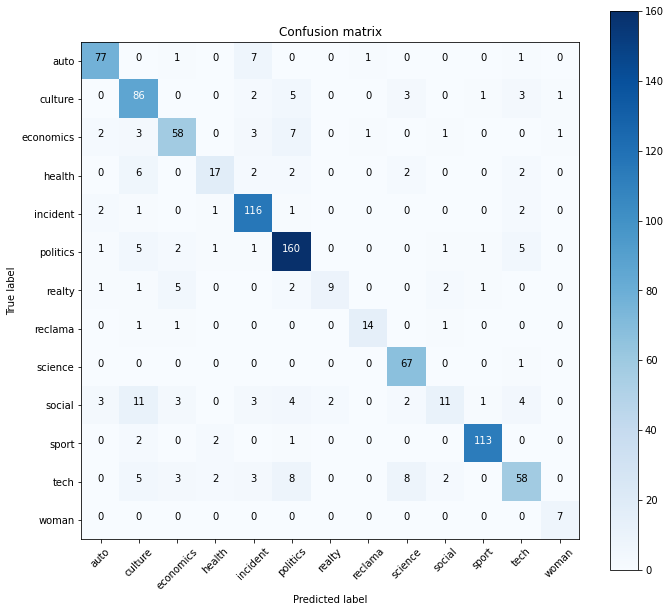

In [19]:
from matplotlib import pyplot as plt
import itertools

classes = sorted(labels.keys())
cm = confusion_matrix(y_test,o)
tick_marks = np.arange(len(classes))

plt.figure(figsize=(10,9))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.title('Confusion matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

plt.show()

---

In [20]:
o = clf.predict(X)

labels_inv = { labels[k]:k for k in labels }

for n in range(10):
    i = rng.randint(len(data))
    print('tag:',data.iloc[i,1])
    print('predict:',labels_inv[o[i]])
    print(re.sub(r'\n\s*\n',' ',data.iloc[i,0][:200])+'...')
    print('- - - - - - - - - - - - - - - - - -')
    

tag: science
predict: science
Недостаток сна вызывает хронические заболевания Владивосток, вторник, 13 декабря , РИА Vladnews. Финские ученые в ходе исследования выяснили, сколько человеку необходимо спать, чтобы хорошенько высп...
- - - - - - - - - - - - - - - - - -
tag: sport
predict: sport
Скардино во второй гонке Кубка мира подряд попала в топ-10 4 декабря 2016 в 14:01 SPORT.TUT.BY Белорусская биатлонистка Надежда Скардино подтвердила свою хорошую форму в гонке преследования на этап...
- - - - - - - - - - - - - - - - - -
tag: incident
predict: incident
На трассе М6 под Щучином Peugeot лоб в лоб столкнулся с МАЗом дорожников: один человек погиб 5 декабря 2016 в 10:30 AUTO.TUT.BY Смертельная авария произошла 3 декабря, в 16.30, на реконструируемом ...
- - - - - - - - - - - - - - - - - -
tag: tech
predict: tech
Российский флот получил первый боевой корабль из стеклопластика 9 декабря 2016 в 16:01 Денис Алдохин / 42.TUT.BY ВМФ России получил минный тральщик проекта 12 700, сообщает ТАС